In [1]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

In [2]:
simulation = Sphere(size = 10, nPoints = 501, volFrac = 0.05)
simulation.place_shape()

volume fraction is 0.00214, radius is 0.99, center at (0.6,-1.7,-2.5) 
volume fraction is 0.00325, radius is 0.99, center at (0.7,-2.0,-2.4) 
volume fraction is 0.00524, radius is 0.99, center at (3.4,0.0,3.0) 
volume fraction is 0.00794, radius is 0.99, center at (2.1,3.6,3.5) 
volume fraction is 0.01177, radius is 0.99, center at (-3.2,1.1,-0.7) 
volume fraction is 0.01695, radius is 0.99, center at (-1.8,-1.3,2.3) 
volume fraction is 0.01902, radius is 0.99, center at (3.3,0.2,0.6) 
volume fraction is 0.02178, radius is 0.99, center at (-0.1,-4.0,-1.4) 
volume fraction is 0.02469, radius is 0.99, center at (-3.5,-1.1,3.3) 
volume fraction is 0.02810, radius is 0.99, center at (1.2,1.5,2.0) 
volume fraction is 0.03179, radius is 0.99, center at (1.6,1.6,0.8) 
volume fraction is 0.03515, radius is 0.99, center at (4.0,-3.6,3.0) 
volume fraction is 0.04005, radius is 0.99, center at (-3.0,1.1,3.0) 
volume fraction is 0.04240, radius is 0.99, center at (-1.7,0.6,-2.7) 
volume fraction i

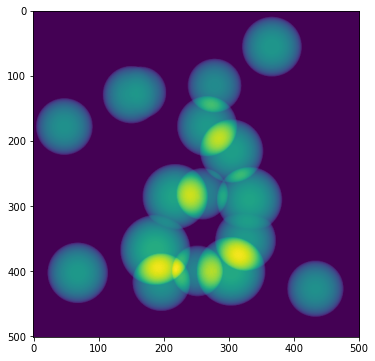

In [3]:
plt.figure(figsize=(6,6))
plt.imshow(simulation.density.sum(axis=0))

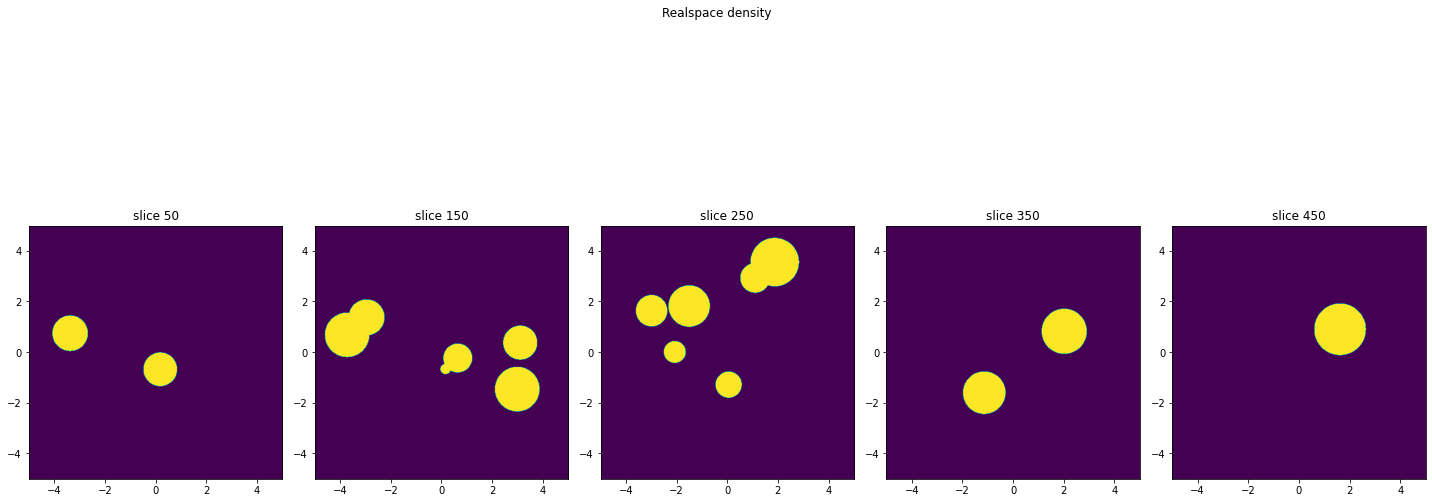

In [3]:
plot_slices(simulation.density, simulation.grid)

In [4]:
#plot_3D_structure(simulation.density, simulation.grid, realspace=True)

In [4]:
simulation.calculate_custom_FTI_3D(device = 'cpu')
simulation.calculate_custom_FTI_3D_slice(device = 'cpu')
simulation.calculate_torch_FTI_3D(device = 'cpu')
simulation.sinc()

/home/slaskina/SAXS-simulations/SAXSsimulations/create_form.py:92: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/Copy.cpp:250.)
  if FT[k,:,:].any():


the maximal difference between the implementation of the FTI is 0.00965864211320877


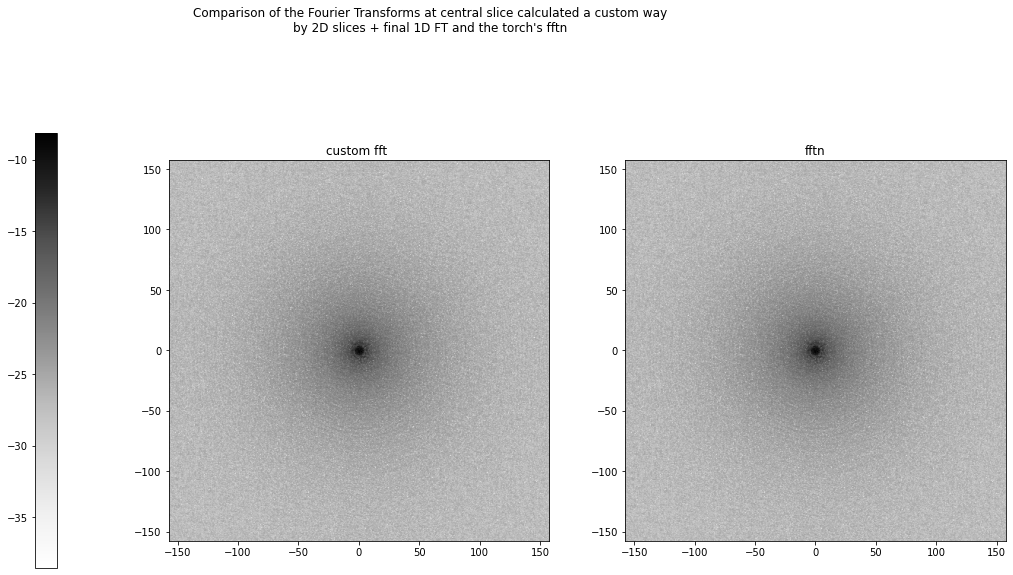

In [5]:
plot_FTI_version_center(simulation.FTI_slice_custom, simulation.FTI_slice_torch, simulation.qx)

the maximal difference between the implementation of the FTI is 0.02568071521818638


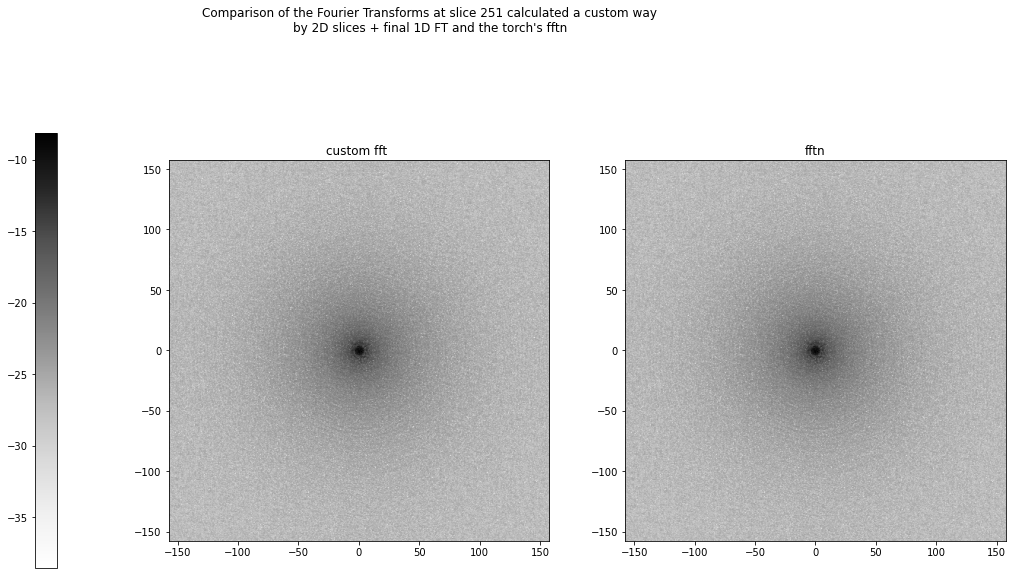

In [6]:
plot_FTI_version(simulation.FTI_custom, simulation.FTI_torch, simulation.qx,slice_number = 251)

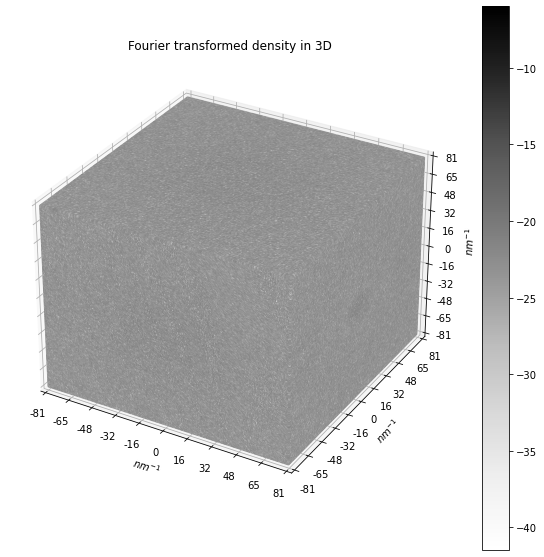

In [19]:
import torch
#plot_3D_structure(torch.from_numpy(simulation.FTI), simulation.qx, realspace= False)#, path = 'figures/FFT_spheres_example.png')

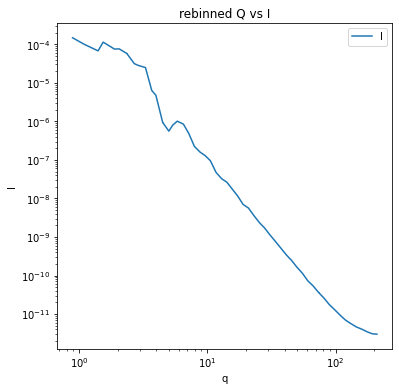

In [8]:
#simulation.reBin(200, slice = 'center')
#simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_slice)

In [10]:
simulation.init_sas_model()

AttributeError: 'Sphere' object has no attribute 'binned_data'

In [38]:
simulation.update_scaling(6.5566e-06)

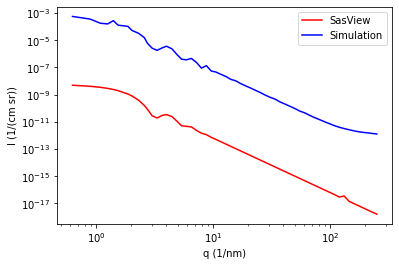

In [39]:
plot_simulation_vs_sas( simulation.binned_data, simulation.qx_sas, simulation.I_sas)

In [9]:
simulation.save_data(directory='dat_files')
print("the sphere file with radius {r:.3f}  is saved".format(r = simulation.rMean))

the sphere file with radius 0.994  is saved


In [5]:
simulation = Sphere(size = 10, nPoints = 501, volFrac = 0.05)
simulation.place_shape(single=True)

volume fraction is 0.00000, radius is 0.01, center at (-2.3,-3.3,-3.0) 


In [1]:
simulation = Cylinder(size = 10, nPoints = 501, volFrac = 0.05)
simulation.place_shape(single = True)

NameError: name 'Cylinder' is not defined

In [6]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

simulation = Cylinder(size = 10, nPoints = 251, volFrac = 0.01)
simulation.place_shape(single = False)
print(simulation.theta, simulation.phi)

volume fraction is 0.00263, height is 5.507, radius is 0.554, center at (0.3,-0.9,0.5) 
--->outside of x plane
--->outside of x plane
--->outside on yz-plane
--->outside on yz-plane
--->outside on yz-plane
volume fraction is 0.00400, height is 5.407, radius is 0.369, center at (1.6,0.8,3.7) 
--->outside of x plane
--->outside of x plane
--->outside on yz-plane
--->outside of x plane
--->outside on yz-plane
volume fraction is 0.00566, height is 5.488, radius is 0.439, center at (0.3,2.3,1.2) 
--->outside on yz-plane
--->outside on yz-plane
--->outside on yz-plane
--->outside of x plane
volume fraction is 0.00796, height is 5.687, radius is 0.508, center at (-1.1,1.8,-2.9) 
volume fraction is 0.00963, height is 5.300, radius is 0.450, center at (1.9,-0.5,-1.4) 
--->outside of x plane
--->outside of x plane
--->outside of x plane
--->outside of x plane
volume fraction is 0.01064, height is 5.517, radius is 0.359, center at (1.5,0.2,3.4) 
49.10317729551976 7.603115517009077


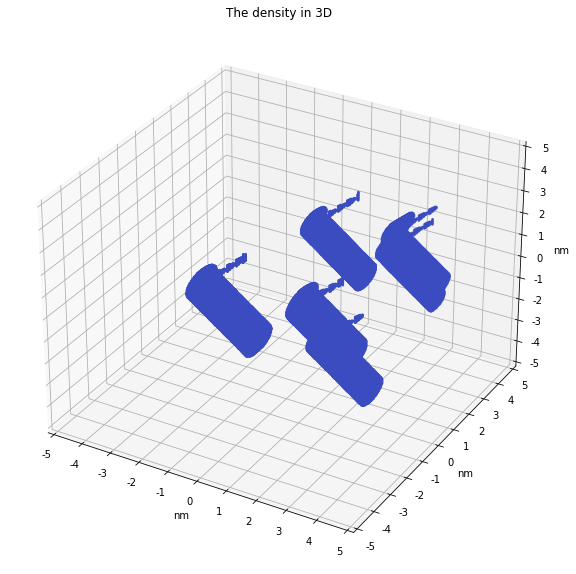

In [7]:
plot_3D_structure(simulation.density, simulation.grid, realspace=True)

49.10317729551976 7.603115517009077


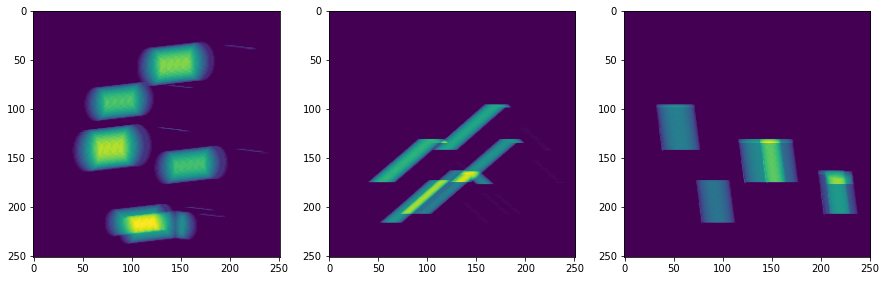

In [12]:
print(simulation.theta, simulation.phi)
fig,axs = plt.subplots(1,3,figsize = (15,5))
ax = axs[0]
im = ax.imshow(simulation.density.sum(axis=0))
ax = axs[1]
im = ax.imshow(simulation.density.sum(axis=1))
ax = axs[2]
im = ax.imshow(simulation.density.sum(axis=2))
plt.show()     

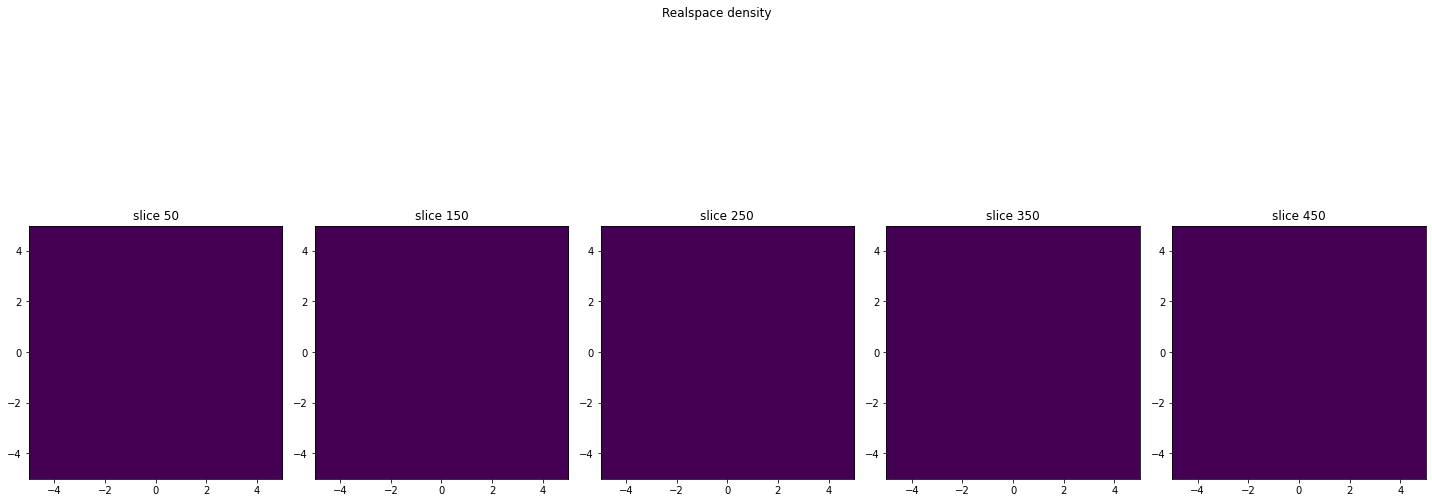

In [4]:
plot_slices(simulation.density, simulation.grid, direction ='x')

the maximal difference between the implementation of the FTI is 0.020268138498067856


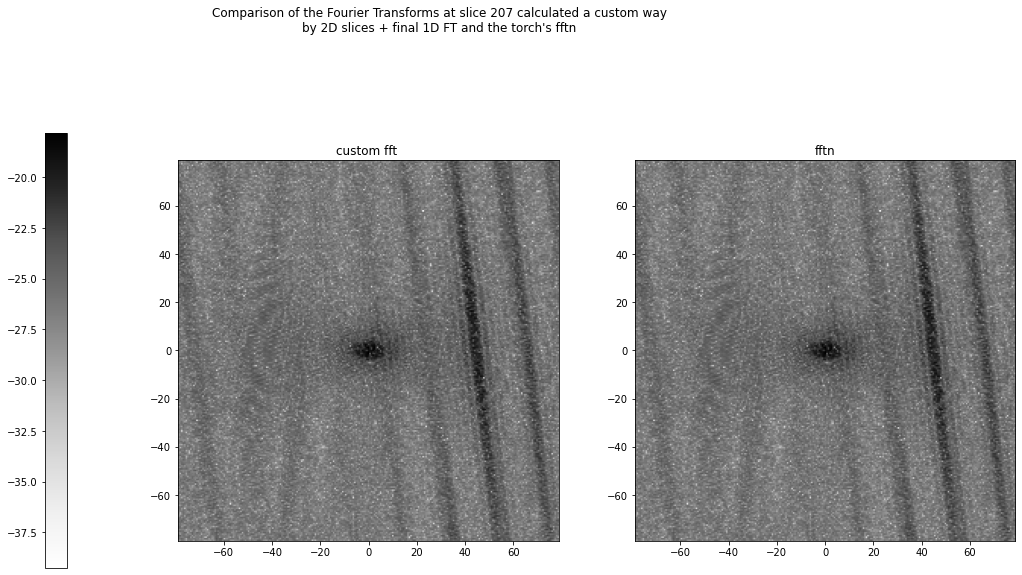

AttributeError: 'Cylinder' object has no attribute 'FTI_slice_custom'

In [8]:
simulation.calculate_custom_FTI_3D(device = 'cpu')
simulation.calculate_torch_FTI_3D(device = 'cpu')
plot_FTI_version(simulation.FTI_custom, simulation.FTI_torch, simulation.qx)
simulation.sinc()

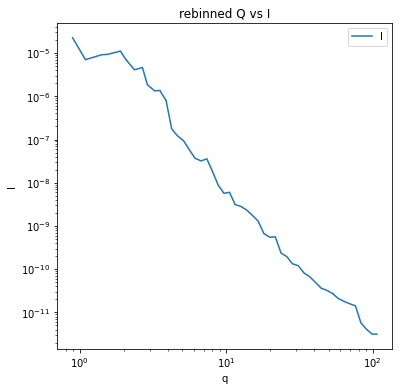

In [10]:

simulation.calculate_custom_FTI_3D_slice(device = 'cpu')
simulation.sinc()
simulation.reBin(200, slice = 'center')
simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_slice)

In [11]:
simulation.save_data(directory='dat_files')
print("the cylinder file with radius {r:.3f} and height {h:.3f} is saved".format(r = simulation.rMean, h = simulation.hMean))

the cylinder file with radius 0.391 and height 5.489 is saved


In [12]:
simulation.reBin(200)
simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_data)

AttributeError: 'Cylinder' object has no attribute 'binned_data'

In [69]:
model = sasmodels.core.load_model('cylinder')

sasmodels.modelinfo.ModelInfo

In [79]:
q = np.geomspace(float(simulation.binned_data['Q'].min()), float(simulation.binned_data['Q'].max()), 501)
Q_sas = np.array(q[np.newaxis, :])
q1 = simulation.binned_data['Q'].values
Q_sas1 = np.array(q1[np.newaxis, :])

In [42]:

modelParameters = model.info.parameters.defaults.copy()
print(modelParameters)

{'scale': 1, 'background': 0.001, 'sld': 4, 'sld_solvent': 1, 'radius': 20, 'length': 400, 'theta': 60, 'phi': 60, 'up_frac_i': 0.0, 'up_frac_f': 0.0, 'up_angle': 0.0, 'up_phi': 0.0, 'sld_M0': 0.0, 'sld_mtheta': 0.0, 'sld_mphi': 0.0, 'sld_solvent_M0': 0.0, 'sld_solvent_mtheta': 0.0, 'sld_solvent_mphi': 0.0}


In [99]:

modelParameters.update({
    'radius': simulation.rMean, 
    'background':0, 
    'scale':3.5979e+15,
    'sld':1.01,
    'sld_solvent':0.01,
    'radius_pd': simulation.rWidth, 
    'radius_pd_type': 'gaussian', 
    'radius_pd_n': 35, 
    'length': simulation.hMean, 
    'length_pd': simulation.hWidth, 
    'length_pd_type': 'gaussian', 
    'length_pd_n': 35, 
    'theta': simulation.theta,
    'phi': simulation.phi
    })
kernel=model.make_kernel(Q_sas)
intensity = sasmodels.direct_model.call_kernel(kernel, modelParameters)

In [100]:

kernel1=model.make_kernel(Q_sas1)
intensity1 = sasmodels.direct_model.call_kernel(kernel1, modelParameters)

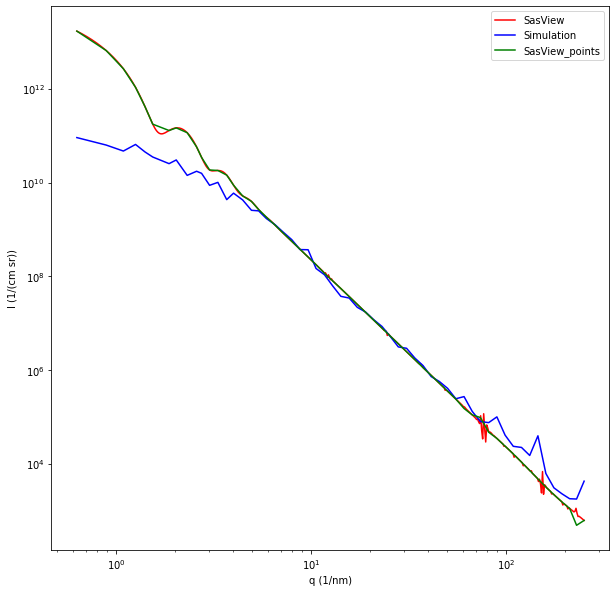

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.plot(q, intensity, '-', color = 'red', label = 'SasView')
plt.plot(simulation.binned_data.Q, simulation.binned_data.I, color = 'blue', label = 'Simulation')
plt.plot(q1, intensity1, '-', color = 'green', label = 'SasView_points')
plt.xlabel("q (1/nm)")
plt.ylabel("I (1/(cm sr))")
plt.xscale('log') 
plt.yscale('log') 
plt.legend()


In [12]:
import numpy as np
import matplotlib.pyplot as plt

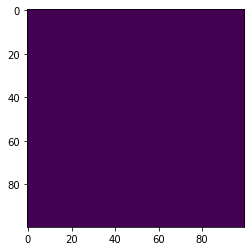

In [14]:
box = np.zeros((100,100))
plt.imshow(box)

In [15]:

u=20     #x-position of the center
v=30    #y-position of the center
a=15     #radius on the x-axis
b=25    #radius on the y-axis

t = np.linspace(0, 2*np.pi, 100)

In [21]:
np.linspace(-5 /2 , 5 /2, 101) 

array([-2.5 , -2.45, -2.4 , -2.35, -2.3 , -2.25, -2.2 , -2.15, -2.1 ,
       -2.05, -2.  , -1.95, -1.9 , -1.85, -1.8 , -1.75, -1.7 , -1.65,
       -1.6 , -1.55, -1.5 , -1.45, -1.4 , -1.35, -1.3 , -1.25, -1.2 ,
       -1.15, -1.1 , -1.05, -1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75,
       -0.7 , -0.65, -0.6 , -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 ,
       -0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,
        0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,
        0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,
        1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ,
        1.55,  1.6 ,  1.65,  1.7 ,  1.75,  1.8 ,  1.85,  1.9 ,  1.95,
        2.  ,  2.05,  2.1 ,  2.15,  2.2 ,  2.25,  2.3 ,  2.35,  2.4 ,
        2.45,  2.5 ])

In [38]:
x=np.arange(100)
x2y = x[None,:]
x2z = x[:,None]
mask = (x2y-u)**2/a**2 + (x2z-v)**2/b**2 <=1

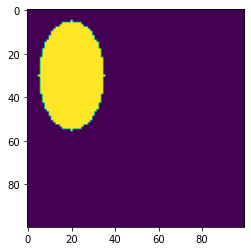

In [39]:
plt.imshow(mask)

In [40]:
first_index = int(np.argwhere(mask.any(axis=1)==1)[0])

In [41]:
cap = 17

In [45]:
mask[first_index+cap:,:] = 0

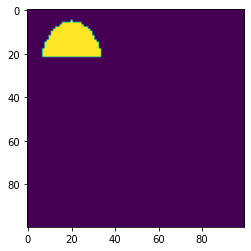

In [46]:
plt.imshow(mask)